In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [309]:
data=pd.read_csv("GlobalTemperatures.csv",header=0,parse_dates=[0])
data.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [310]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   dt                                         3192 non-null   datetime64[ns]
 1   LandAverageTemperature                     3180 non-null   float64       
 2   LandAverageTemperatureUncertainty          3180 non-null   float64       
 3   LandMaxTemperature                         1992 non-null   float64       
 4   LandMaxTemperatureUncertainty              1992 non-null   float64       
 5   LandMinTemperature                         1992 non-null   float64       
 6   LandMinTemperatureUncertainty              1992 non-null   float64       
 7   LandAndOceanAverageTemperature             1992 non-null   float64       
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64       
dtypes: datetime64[ns](1)

In [311]:
data.duplicated().sum()

0

In [312]:
data['dt'][0]

Timestamp('1750-01-01 00:00:00')

In [313]:
data.isnull().sum()

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

In [314]:
data.shape

(3192, 9)

Only date column has no missing values.

In [315]:
#Let vreate year feature
data['Year']=data['dt'].dt.year

In [316]:
data.groupby('Year').agg({'LandAverageTemperature':'mean','LandAverageTemperatureUncertainty':'mean'})

,LandAverageTemperature,LandAverageTemperatureUncertainty
Year,,
1750,8.719364,2.637818
1751,7.976143,2.781143
1752,5.779833,2.977000
1753,8.388083,3.176000
1754,8.469333,3.494250
...,...,...
2011,9.516000,0.082000
2012,9.507333,0.083417
2013,9.606500,0.097667


In [317]:
df=data.groupby('Year').agg({'LandAverageTemperature':'mean','LandAverageTemperatureUncertainty':'mean'}).reset_index()
df

,Year,LandAverageTemperature,LandAverageTemperatureUncertainty
0,1750,8.719364,2.637818
1,1751,7.976143,2.781143
2,1752,5.779833,2.977000
3,1753,8.388083,3.176000
4,1754,8.469333,3.494250
...,...,...,...
261,2011,9.516000,0.082000
262,2012,9.507333,0.083417
263,2013,9.606500,0.097667
264,2014,9.570667,0.090167


In [318]:
#Finding min and max uncertainity of avg temperatures for each year
df['Max_uncertainity']=df['LandAverageTemperature'] + df['LandAverageTemperatureUncertainty']
df['Min_uncertainity']=df['LandAverageTemperature'] - df['LandAverageTemperatureUncertainty']

In [319]:
df.head(3)

,Year,LandAverageTemperature,LandAverageTemperatureUncertainty,Max_uncertainity,Min_uncertainity
0,1750,8.719364,2.637818,11.357182,6.081545
1,1751,7.976143,2.781143,10.757286,5.195000
2,1752,5.779833,2.977000,8.756833,2.802833


In [320]:
#Let plot our dataframe in a multiline chart
df.columns

Index(['Year', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'Max_uncertainity', 'Min_uncertainity'],
      dtype='object')

<AxesSubplot:xlabel='Year'>

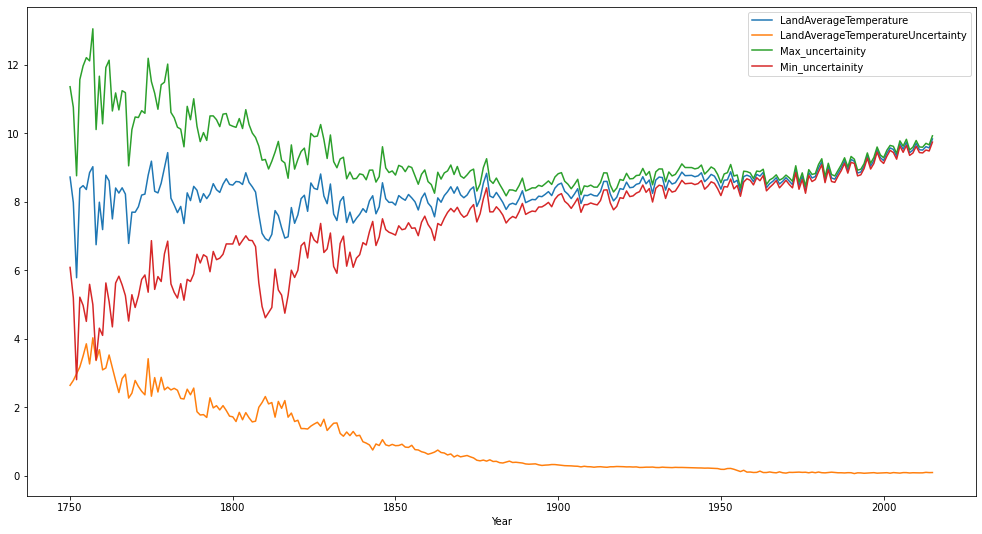

In [321]:
df.plot(x='Year',y=['LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'Max_uncertainity', 'Min_uncertainity'],figsize=(17,9))

## Avg Temp of Season

In order to find seasons, we will extract months from year column and afterwards define the seasons through costumized function.

In [322]:
data['Month']=data['dt'].dt.month

In [323]:
data.head(2)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,Year,Month
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN,1750,1
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN,1750,2


In [324]:
data['Month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [325]:
def to_season(month):
    
    if month>=3 and month<=5:
        return 'spring'
    elif month>=6 and month<=8:
        return'summer'
    elif month>=9 and month<=11:
        return'autumn'
    else:
        return'winter'
    
        
    

In [326]:
data['Season']=data['Month'].apply(to_season)

In [327]:
data.head(4)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,Year,Month,Season
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN,1750,1,winter
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN,1750,2,winter
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN,1750,3,spring
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN,1750,4,spring


Now we will compute season's avg temperature by year. We will create a new dataframe where for each year, we will add seasons avg temperature

In [328]:
years=data.Year.unique()

In [329]:
spring_season=[]
summer_season=[]
autumn_season=[]
winter_season=[]

In [330]:
for year in years:
    curr_year=data[data['Year']==year]
    spring_season.append(curr_year[curr_year['Season']=='spring']['LandAverageTemperature'].mean())
    summer_season.append(curr_year[curr_year['Season']=='summer']['LandAverageTemperature'].mean())
    autumn_season.append(curr_year[curr_year['Season']=='autumn']['LandAverageTemperature'].mean())
    winter_season.append(curr_year[curr_year['Season']=='winter']['LandAverageTemperature'].mean())

In [331]:
seasons_df=pd.DataFrame()

In [332]:
seasons_df['Years']=years
seasons_df['Spring']=spring_season
seasons_df['Summer']=summer_season
seasons_df['Autumn']=autumn_season
seasons_df['Winter']=winter_season

In [333]:
seasons_df

,Years,Spring,Summer,Autumn,Winter
0,1750,8.563000,14.518333,8.890000,2.963000
1,1751,6.735000,14.116000,10.673000,1.729000
2,1752,7.035500,NaN,7.587000,2.717000
3,1753,8.627333,14.608333,9.212333,1.104333
4,1754,9.074333,14.208333,8.957333,1.637333
...,...,...,...,...,...
261,2011,9.190000,14.954667,10.026000,3.893333
262,2012,9.429667,14.762667,10.208000,3.629000
263,2013,9.166667,14.771000,10.278000,4.210333
264,2014,9.516333,14.694333,10.044667,4.027333


In [334]:
seasons_df.columns

Index(['Years', 'Spring', 'Summer', 'Autumn', 'Winter'], dtype='object')

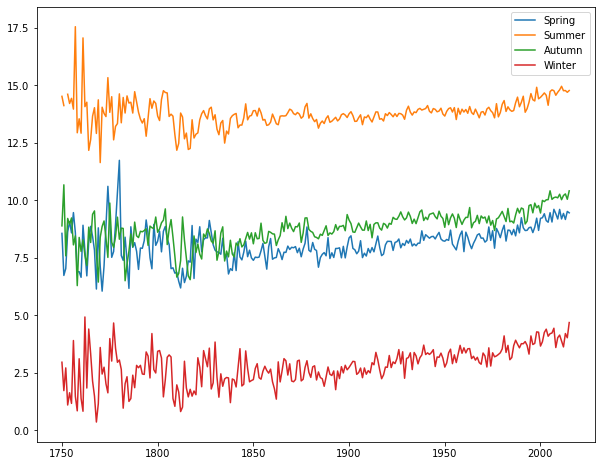

In [335]:
plt.figure(figsize=(10,8))
plt.plot(seasons_df['Years'],seasons_df[['Spring', 'Summer', 'Autumn', 'Winter']])
plt.legend(['Spring', 'Summer', 'Autumn', 'Winter'])
plt.show()

We notice that avg temp  of season is raising. Seasons are getting warmer.

## Data Preparation

In [336]:
cities=pd.read_csv('GlobalLandTemperaturesByCity.csv',header=0,parse_dates=[0])
cities.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [337]:
cities.shape

(8599212, 7)

We will take into consideration sampling as the dataset is huge.


In [338]:
cities.Country.unique()

array(['Denmark', 'Turkey', 'Kazakhstan', 'China', 'Spain', 'Germany',
       'Nigeria', 'Iran', 'Russia', 'Canada', "Côte D'Ivoire",
       'United Kingdom', 'Saudi Arabia', 'Japan', 'United States',
       'India', 'Benin', 'United Arab Emirates', 'Mexico', 'Venezuela',
       'Ghana', 'Ethiopia', 'Australia', 'Yemen', 'Indonesia', 'Morocco',
       'Pakistan', 'France', 'Libya', 'Burma', 'Brazil', 'South Africa',
       'Syria', 'Egypt', 'Algeria', 'Netherlands', 'Malaysia', 'Portugal',
       'Ecuador', 'Italy', 'Uzbekistan', 'Philippines', 'Madagascar',
       'Chile', 'Belgium', 'El Salvador', 'Romania', 'Peru', 'Colombia',
       'Tanzania', 'Tunisia', 'Turkmenistan', 'Israel', 'Eritrea',
       'Paraguay', 'Greece', 'New Zealand', 'Vietnam', 'Cameroon', 'Iraq',
       'Afghanistan', 'Argentina', 'Azerbaijan', 'Moldova', 'Mali',
       'Congo (Democratic Republic Of The)', 'Thailand',
       'Central African Republic', 'Bosnia And Herzegovina', 'Bangladesh',
       'Switzerland'

In [339]:
usa=cities[cities['Country']=='United States']

In [340]:
usa.City.unique()

array(['Abilene', 'Akron', 'Albuquerque', 'Alexandria', 'Allentown',
       'Amarillo', 'Anaheim', 'Anchorage', 'Ann Arbor', 'Antioch',
       'Arlington', 'Arvada', 'Atlanta', 'Aurora', 'Austin',
       'Bakersfield', 'Baltimore', 'Baton Rouge', 'Beaumont', 'Bellevue',
       'Berkeley', 'Birmingham', 'Boston', 'Bridgeport', 'Brownsville',
       'Buffalo', 'Burbank', 'Cambridge', 'Cape Coral', 'Carrollton',
       'Cary', 'Cedar Rapids', 'Chandler', 'Charleston', 'Charlotte',
       'Chattanooga', 'Chesapeake', 'Chicago', 'Chula Vista',
       'Cincinnati', 'Clarksville', 'Clearwater', 'Cleveland',
       'Colorado Springs', 'Columbia', 'Columbus', 'Concord',
       'Coral Springs', 'Corona', 'Corpus Christi', 'Costa Mesa',
       'Dallas', 'Dayton', 'Denton', 'Denver', 'Des Moines', 'Detroit',
       'Downey', 'Durham', 'East Los Angeles', 'Edison', 'El Monte',
       'El Paso', 'Elizabeth', 'Escondido', 'Eugene', 'Evansville',
       'Fairfield', 'Fayetteville', 'Flint', 'Fontana',

In [341]:
usa_cities=['New York','San Francisco','Paradise']

In [342]:
my_data=usa[usa['City'].isin(usa_cities)]

In [343]:
my_data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
5203973,1743-11-01,3.264,1.665,New York,United States,40.99N,74.56W
5203974,1743-12-01,NaN,NaN,New York,United States,40.99N,74.56W
5203975,1744-01-01,NaN,NaN,New York,United States,40.99N,74.56W
5203976,1744-02-01,NaN,NaN,New York,United States,40.99N,74.56W
5203977,1744-03-01,NaN,NaN,New York,United States,40.99N,74.56W


In [344]:
my_data.isnull().sum()

dt                                 0
AverageTemperature               207
AverageTemperatureUncertainty    207
City                               0
Country                            0
Latitude                           0
Longitude                          0
dtype: int64

In [345]:
my_data.dropna(inplace=True)

<ipython-input-345-73a5110b8ac4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data.dropna(inplace=True)


In [346]:
my_data.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

In [347]:
my_data=my_data.set_index('dt')

### Seasonality (mean&variance of data NOT constant)

In [348]:
my_data.head(2)

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,3.264,1.665,New York,United States,40.99N,74.56W
1744-04-01,9.788,2.151,New York,United States,40.99N,74.56W


In [349]:
my_data['Year']=my_data.index.year

In [350]:
my_data['Month']=my_data.index.month

In [351]:
my_data.head(3)

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year,Month
dt,,,,,,,,
1743-11-01,3.264,1.665,New York,United States,40.99N,74.56W,1743,11
1744-04-01,9.788,2.151,New York,United States,40.99N,74.56W,1744,4
1744-05-01,15.708,1.506,New York,United States,40.99N,74.56W,1744,5


In [352]:
pivot=my_data.pivot_table(values='AverageTemperature',index='Month',columns='Year')

In [353]:
pivot

Year,1743,1744,1745,1750,1751,1752,1753,1754,1755,1756,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Month,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,-2.363,-4.310,-3.591,-7.588,-3.122,-2.252,-3.193,-1.985,...,3.059333,4.283667,6.376333,4.553667,4.209000,4.340333,4.643333,3.954000,6.002333,4.229000
2,NaN,NaN,-2.671,-2.719,-2.051,NaN,-1.467,-2.583,-1.802,0.259,...,5.406333,6.722667,6.861333,5.241333,6.099000,6.071333,6.186000,5.303000,7.503333,5.623000
3,NaN,NaN,1.363,2.773,3.256,3.322,4.207,2.728,1.112,NaN,...,12.326333,9.024667,7.859333,10.694667,9.618667,9.329333,10.216333,9.327333,11.080667,10.384667
4,NaN,9.788,8.209,8.848,7.992,7.402,8.099,NaN,8.714,NaN,...,14.244667,13.040333,13.234000,13.364667,13.594000,13.324333,12.952000,13.255333,14.018667,14.612667
5,NaN,15.708,NaN,15.411,NaN,NaN,15.330,NaN,15.238,NaN,...,19.157000,17.471000,18.968667,18.931000,16.874667,19.331000,16.790000,16.765333,19.390000,18.498000
6,NaN,21.210,NaN,19.017,20.724,NaN,20.820,20.075,19.964,20.488,...,22.115333,21.952000,23.259667,22.640333,23.102333,20.911667,22.649333,21.557333,22.309667,23.383333
7,NaN,22.207,NaN,24.203,22.668,NaN,22.524,22.503,NaN,22.452,...,24.287333,25.632333,26.143000,24.838333,25.049667,24.234333,25.366333,24.632000,24.615000,25.692333
8,NaN,NaN,NaN,22.135,21.547,NaN,21.324,21.461,NaN,21.208,...,23.812333,24.381000,23.814333,24.307333,24.127333,24.213333,23.608000,24.049667,24.597667,23.187667
9,NaN,14.922,NaN,17.445,15.812,NaN,15.548,16.281,16.137,17.345,...,21.286333,20.734667,20.076667,20.891333,21.618000,21.661333,21.792000,21.946000,21.300000,21.196000


Text(0, 0.5, 'Temperatures')

<Figure size 1440x648 with 0 Axes>

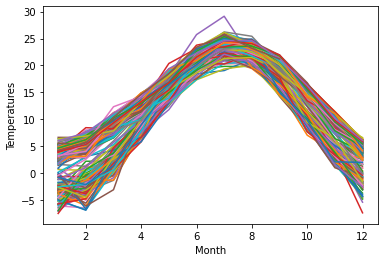

In [354]:
plt.figure(figsize=(20,9))
pivot.plot()
plt.legend().remove()
plt.xlabel('Month')
plt.ylabel('Temperatures')

We can notice seasonality in the figure above. Temperatures for each month seem to follow a similiar trend also.<br>
So from visualization we can notice data being not stationary.Another way is by applying statistical test i.e addfuller.

In [355]:
adfuller(my_data['AverageTemperature'])

(-1.7401725372091708,
 0.41054220087920834,
 35,
 7118,
 {'1%': -3.4312690306005167,
  '5%': -2.8619461387496887,
  '10%': -2.5669861835674803},
 28934.64725597252)

In [356]:
def adfuller_test(data):
    result=adfuller(data)
    labels=['AD statistic','Pval','lags','nr_obv']
    for value,label in zip(result,labels):
        print(label + ' :' + str(value))
    if result[1] <=0.05:
        print("Reject the null hypothesis, data is stationary")
    else:
        print("Fail to reject the null hypothesis, data is not stationary")

In [357]:
adfuller_test(my_data['AverageTemperature'])

AD statistic :-1.7401725372091708
Pval :0.41054220087920834
lags :35
nr_obv :7118
Fail to reject the null hypothesis, data is not stationary


We have noticed earlier that our data has yearly seasonality. hence we shift the values by 12.

In [358]:
my_data.head(3)

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year,Month
dt,,,,,,,,
1743-11-01,3.264,1.665,New York,United States,40.99N,74.56W,1743,11
1744-04-01,9.788,2.151,New York,United States,40.99N,74.56W,1744,4
1744-05-01,15.708,1.506,New York,United States,40.99N,74.56W,1744,5


In [359]:
data_differenciated=my_data[['AverageTemperature','Month']]

In [360]:
data_differenciated['diff_temp']=data_differenciated['AverageTemperature']-data_differenciated['AverageTemperature'].shift(12)

<ipython-input-360-9cb2cf767a21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_differenciated['diff_temp']=data_differenciated['AverageTemperature']-data_differenciated['AverageTemperature'].shift(12)


In [361]:
data_differenciated

,AverageTemperature,Month,diff_temp
dt,,,
1743-11-01,3.264,11,NaN
1744-04-01,9.788,4,NaN
1744-05-01,15.708,5,NaN
1744-06-01,21.210,6,NaN
1744-07-01,22.207,7,NaN
...,...,...,...
2013-05-01,17.434,5,0.879
2013-06-01,19.759,6,1.277
2013-07-01,20.657,7,1.025


In [362]:
adfuller(data_differenciated['diff_temp'].dropna())

(-21.245514607771018,
 0.0,
 35,
 7106,
 {'1%': -3.4312705831413144,
  '5%': -2.8619468247435202,
  '10%': -2.566986548733429},
 29716.912902288343)

In [363]:
adfuller_test(data_differenciated['diff_temp'].dropna())

AD statistic :-21.245514607771018
Pval :0.0
lags :35
nr_obv :7106
Reject the null hypothesis, data is stationary


<AxesSubplot:xlabel='dt'>

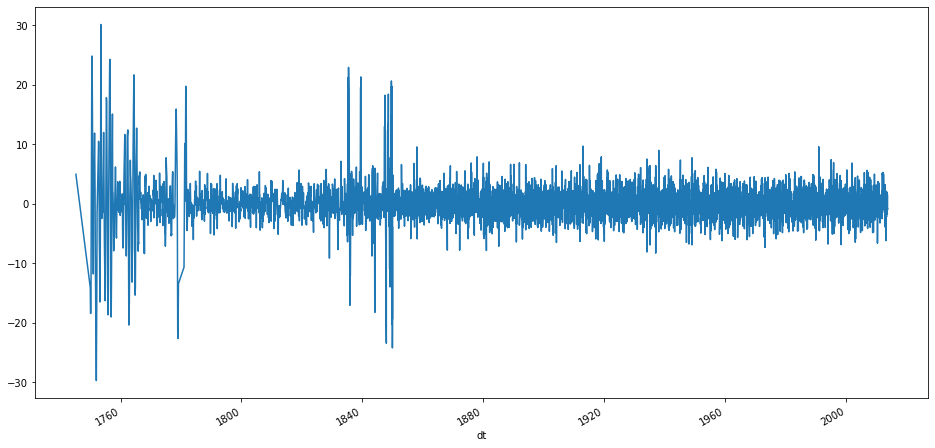

In [364]:
data_differenciated['diff_temp'].plot(figsize=(16,8))

In [365]:
#Building model ARIMA

In [366]:
model_data=data_differenciated[['diff_temp']]

In [367]:
model_data['diff_temp'].dropna(inplace=True)

<ipython-input-367-182d6396b34f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['diff_temp'].dropna(inplace=True)


In [368]:
model_data['diff_temp']

dt
1743-11-01      NaN
1744-04-01      NaN
1744-05-01      NaN
1744-06-01      NaN
1744-07-01      NaN
              ...  
2013-05-01    0.879
2013-06-01    1.277
2013-07-01    1.025
2013-08-01   -0.800
2013-09-01    1.426
Name: diff_temp, Length: 7154, dtype: float64

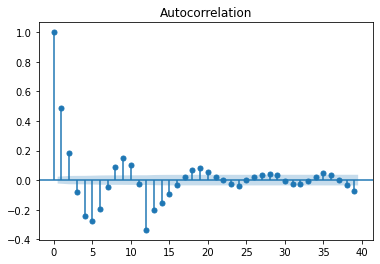

In [369]:
plot_acf(model_data['diff_temp'].dropna())
plt.show() #q=11

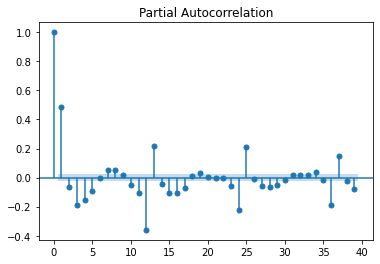

In [370]:
plot_pacf(model_data['diff_temp'].dropna())
plt.show() #p=6

In [371]:

df=model_data[['diff_temp']]

In [372]:
df.dropna(inplace=True)

In [373]:
df.shape

(7142, 1)

In [374]:
train=df[0:6000]
test=df[6000:]

In [375]:
arima=ARIMA(train, order=(6,1,11))

C:\Users\Gerta\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Gerta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [376]:
model_fit=arima.fit()

C:\Users\Gerta\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Gerta\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Gerta\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import

In [386]:
predicted_val=model_fit.forecast(steps=len(test))

In [387]:
predicted_val

(array([ 0.79738453, -1.17734084, -1.31553194, ..., -0.03155216,
        -0.03156029, -0.03156841]),
 array([1.99815719, 2.34942024, 2.49561203, ..., 3.20068274, 3.20068364,
        3.20068454]),
 array([[-3.1189316 ,  4.71370066],
        [-5.78211989,  3.42743822],
        [-6.20684164,  3.57577776],
        ...,
        [-6.30477505,  6.24167073],
        [-6.30478494,  6.24166437],
        [-6.30479484,  6.24165802]]))

In [388]:
len(predicted_val)

3

In [389]:
predarr1=predicted[0]

In [390]:
print(len(test))
print(len(predarr1))

1142
1142


In [394]:

np.sqrt(mean_squared_error(test,predarr1))

1.4961077911959164

In [395]:
forecasted_data=[[test,predarr1]]